### Importing necessary libraries

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from string import punctuation
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, adjusted_rand_score, confusion_matrix, f1_score, rand_score, roc_auc_score, roc_curve, auc, silhouette_score 
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import warnings 
warnings.filterwarnings('ignore')

## Data Collection

We shall import the datasets into train and test and divide the training data into X_train and Y_train. This X_train and Y_train will be further divided into X_train, X_validation Y_train and Y_validation in the later stages.

In [102]:
# Uploading the Training.csv and Test.csv from the kaggle competition
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

# print(train)
# print(test)

X_train = train.iloc[:, 1:]
Y_train = train['overall']

# Add column name to Y_train, i.e., overall
Y_train = pd.DataFrame(Y_train, columns = ['overall'])

# print(X_train)
# print("--------------xxxxxxxxxx------------")
# print(Y_train)


## Data Processing

In this step we shall process our data to obtain the desired results. Some of the data processing steps include -

1. Converting the NaN values to some default value in case of 'vote' column
2. Converting multiclass labels to binary labels according to an input threshold for binary classification experiment
3. Removing irrelevant columns from the X_train and test set. They include - 'reviewTime', 'reviewerName', 'unixReviewTime', 'style', 'image','reviewerID', 'asin' and 'category'

In [103]:
def label_ecoding(ser):
  """
  This function converts a series to the label encoded version of the same series

      Parameters:
              ser (pandas.Series): A pandas Series of strings

      Returns:
              ser_labelled (pandas.Series): A labelled pandas Series of integers
  """
  le = preprocessing.LabelEncoder()
  ser_labelled = le.fit_transform(ser)
  return ser_labelled


def vectorize(ser):
  """
  This function converts a series to a vectorized form of numbers

      Parameters:
              ser (pandas.Series): A pandas Series of strings

      Returns:
              ser (pandas.DataFrame): A pandas DataFrame consisting of columns of vectorized words from the input
  """
  ser = [str (item) for item in ser]
  tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english', max_features=100)
  tfidf_wm = tfidfvectorizer.fit_transform(ser)
  ser = pd.DataFrame(tfidf_wm.todense())
  return ser


def data_processing_test(test):
  """
  This function converts the test dataset to a cleaned and processed dataset in 
  accordance with the steps defined above

      Parameters:
              test (pandas.DataFrame): A pandas DataFrame of test dataset

      Returns:
              test (pandas.DataFrame): A pandas DataFrame of test dataset which 
                                        has been preprocessed
  """

  # Drop the irrelevant columns from the
  test.drop(columns = ['reviewTime', 'reviewerName', 'unixReviewTime', 'style', 'image','reviewerID', 'asin', 'category'], 
            inplace=True)
  
  # Convert reviewText and summary to Count Vectors
  review_text = test['reviewText']
  test.drop(columns = ['reviewText'], inplace=True)
  test = pd.concat([test, vectorize(review_text)], axis=1)

  summary = test['summary']
  test.drop(columns = ['summary'], inplace=True)
  test = pd.concat([test, vectorize(summary)], axis=1)
  
  # Convert NaN values in the vote column to zero
  test['vote'] = test['vote'].fillna(0)
 
  # Convert column names to strings
  test.columns = test.columns.astype('str')
  
  return test


def data_processing(threshold, X_train1, Y_train1):
  """
  This function converts the training dataset to a cleaned and processed dataset in 
  accordance with the steps defined above

      Parameters:
              threshold (int): A number denoting the boundary of division of labels of training set
              X_train (pandas.DataFrame): A pandas DataFrame of training dataset containing features
              Y_train (pandas.DataFrame): A pandas DataFrame of training dataset containing labels

      Returns:
              X_train (pandas.DataFrame): A pandas DataFrame of processed training dataset containing features
              Y_train (pandas.DataFrame): A pandas DataFrame of processed training dataset containing labels
  """

  # Drop the irrelevant columns from the X_train
  X_train1.drop(columns = ['reviewTime', 'reviewerName', 'unixReviewTime', 'style', 'image', 'reviewerID', 'asin', 'category'], 
               inplace=True)
  

  # Convert reviewText and summary to Count Vectors
  review_text = X_train1['reviewText']
  X_train1.drop(columns = ['reviewText'], inplace=True)
  X_train1 = pd.concat([X_train1, vectorize(review_text)], axis=1)

  summary = X_train1['summary']
  X_train1.drop(columns = ['summary'], inplace=True)
  X_train1 = pd.concat([X_train1, vectorize(summary)], axis=1)


  # Convert NaN values in the vote column to zero
  X_train1['vote'] = X_train1['vote'].fillna(0)
  
  # Convert labels in Y_train which are less than and equal to threshold to zero 
  # and rest as one
  Y_train1.loc[Y_train1['overall'] <= threshold] = 0
  Y_train1.loc[Y_train1['overall'] > threshold] = 1

  # Convert column names to strings
  X_train1.columns = X_train1.columns.astype('str')
  Y_train1.columns = Y_train1.columns.astype('str')

  return X_train1, Y_train1


def data_processing_multiclass(X_train1, Y_train1, clustering=False):
  """
  This function converts the training dataset to a cleaned and processed dataset in 
  accordance with the steps defined earlier without the threshold for binary classification

      Parameters:
              X_train (pandas.DataFrame): A pandas DataFrame of training dataset containing features
              Y_train (pandas.DataFrame): A pandas DataFrame of training dataset containing labels

      Returns:
              X_train (pandas.DataFrame): A pandas DataFrame of processed training dataset containing features
              Y_train (pandas.DataFrame): A pandas DataFrame of processed training dataset containing labels
  """
  # Drop the irrelevant columns from the X_train
  X_train1.drop(columns = ['reviewTime', 'reviewerName', 'unixReviewTime', 'style', 'image', 'reviewerID', 'asin','category'], 
                inplace=True)
  

  # Convert reviewText, category and summary to Count Vectors
  X_train1['reviewText'] = X_train1['reviewText'].str.replace('[^\w\s]','')
  review_text = X_train1['reviewText']
  X_train1.drop(columns = ['reviewText'], inplace=True)
  X_train1 = pd.concat([X_train1, vectorize(review_text)], axis=1)

  X_train1['summary'] = X_train1['summary'].str.replace('[^\w\s]','')
  summary = X_train1['summary']
  X_train1.drop(columns = ['summary'], inplace=True)
  X_train1 = pd.concat([X_train1, vectorize(summary)], axis=1)


  # Convert categories into numerical values if this is for a clustering algorithm
  if clustering:
    categories = Y_train1['category'].unique().tolist()
    for idx in range(Y_train1['category'].shape[0]):
      for idx1 in range(len(categories)):
        if Y_train1['category'].loc[idx] == categories[idx1]:
          Y_train1['category'].loc[idx] = idx1
          break
    
    Y_train1 = Y_train1.astype('int')
    Y_train1.columns = Y_train1.columns.astype('str')



  # Convert NaN values in the vote column to zero
  X_train1['vote'] = X_train1['vote'].fillna(0)
  

  X_train1.columns = X_train1.columns.astype('str')
  Y_train1.columns = Y_train1.columns.astype('str')

  return X_train1, Y_train1


## Calling the preprocessing function for test data as it needs to be done only once
test = data_processing_test(test)

In [98]:
def find_curves(y_true, y_scores):
  # Calculate ROC AUC score
  roc_auc = roc_auc_score(y_true, y_scores)

  # Calculate false positive rate and true positive rate for ROC curve
  fpr, tpr, thresholds = roc_curve(y_true, y_scores)

  # Plot ROC curve
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  plt.show()

  # Calculate and plot confusion matrix
  y_pred = np.where(y_scores > 0.5, 1, 0)
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  conf_matrix = np.array([[tp, fp], [fn, tn]])
  plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion matrix')
  plt.colorbar()
  plt.xticks([0, 1], ['Positive', 'Negative'])
  plt.yticks([0, 1], ['Positive', 'Negative'])
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  thresh = conf_matrix.max() / 2
  for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
      plt.text(j, i, format(conf_matrix[i, j], 'd'), horizontalalignment="center", color="white" if conf_matrix[i, j] > thresh else "black")
  plt.show()

# Binary Classification

The next 12 models are used for binary classification. The cutoff has already been provided as 1,2,3 and 4.

## Cutoff - 1

The labels having value less than equal to 1 will become 0 and rest will be 1. I have called the data_processing function to make the changes to Y_train

In [104]:
# Perform the data processing here

# Cutoff: 1
X_train1 = train.iloc[:, 1:]
Y_train1 = train['overall']
Y_train1 = pd.DataFrame(Y_train1, columns = ['overall'])
X_train1, Y_train1 = data_processing(1, X_train1, Y_train1)


# Divide the training data provided into train and validation sets 
X_train1, X_validation1, Y_train1, Y_validation1 = train_test_split(X_train1, 
                                                                    Y_train1, 
                                                                    test_size=0.2, 
                                                                    train_size=0.8)


### Cutoff - 1
### Model 1: Logistic Regression

F1 score for Logistic Regression is 0.7004077969825029
Confusion matrix for Logistic Regression is [[ 953  252]
 [1175 3458]]
AUROC for Logistic Regression is 0.7686280006412592
Accuracy Score for Logistic Regression is 0.7578262494169419
Best hyperparameters: {'C': 1, 'penalty': 'l2'}


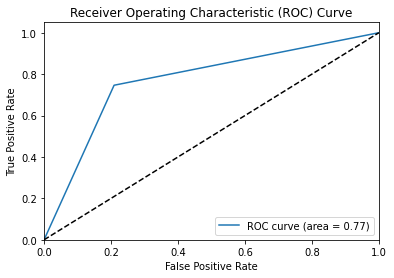

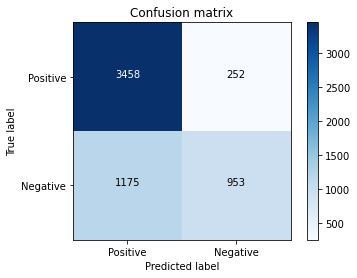

In [105]:
# Cutoff: 1
# Model 1: Logistic Regression

# Define hyperparameters for grid search
param_grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}

# Training an ML model here
lr = LogisticRegression(random_state=0, class_weight="balanced")
clf_lr = GridSearchCV(lr, param_grid, cv=3)
clf_lr.fit(X_train1, Y_train1)
Y_validation_pred1 = clf_lr.predict(X_validation1)

print("F1 score for Logistic Regression is", f1_score(Y_validation1, 
                                                      Y_validation_pred1, 
                                                      average='macro'))
print("Confusion matrix for Logistic Regression is", confusion_matrix(Y_validation1, 
                                                                      Y_validation_pred1))
print("AUROC for Logistic Regression is", roc_auc_score(Y_validation1, 
                                                           Y_validation_pred1))
print("Accuracy Score for Logistic Regression is", clf_lr.best_score_)
print("Best hyperparameters:", clf_lr.best_params_)

find_curves(Y_validation1, Y_validation_pred1)

### Cutoff - 1
### Model 2: SVM

F1 score for SVM is 0.7083579284218294
Confusion matrix for SVM is [[ 906  299]
 [1044 3589]]
AUROC for SVM is 0.7632636337012215
Accuracy Score for SVM is 0.7609952088988673
Best hyperparameters: {'C': 10, 'loss': 'squared_hinge', 'penalty': 'l2'}


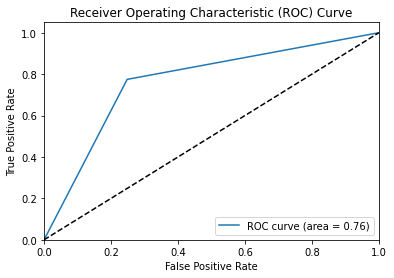

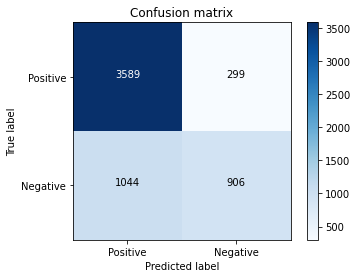

In [109]:
# Cutoff: 1
# Model 2: SVM

# Define hyperparameters for grid search
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge']
}

# Training an ML model here
svc = svm.LinearSVC(class_weight="balanced")
clf_svm = GridSearchCV(svc, param_grid, cv=3)
clf_svm.fit(X_train1, Y_train1)
Y_validation_pred2 = clf_svm.predict(X_validation1)

print("F1 score for SVM is", f1_score(Y_validation1, Y_validation_pred2, average='macro'))
print("Confusion matrix for SVM is", confusion_matrix(Y_validation1, Y_validation_pred2))
print("AUROC for SVM is", roc_auc_score(Y_validation1, Y_validation_pred2))
print("Accuracy Score for SVM is", clf_svm.best_score_)
print("Best hyperparameters:", clf_svm.best_params_)

find_curves(Y_validation1, Y_validation_pred2)

### Cutoff - 1
### Model 3: Random Forest

F1 score for Random Forest is 0.682819424764087
Confusion matrix for Random Forest is [[ 465  740]
 [ 298 4335]]
AUROC for Random Forest is 0.6607854709986897
Accuracy Score for Random Forest is 0.8332404137811977
Best hyperparameters: {'max_depth': None, 'n_estimators': 200}


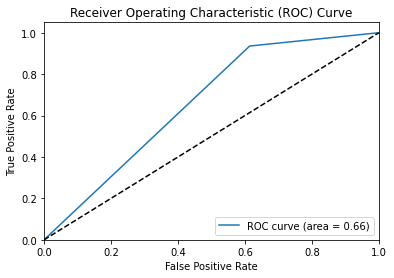

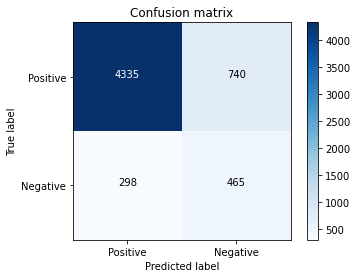

In [110]:
# Cutoff: 1
# Model 3: Random Forest

# Define hyperparameters for grid search
param_grid = {'n_estimators': [10, 200],
              'max_depth': [None, 5, 10, 20]}

# Training an ML model here
rf = RandomForestClassifier(max_depth=2, random_state=0, class_weight="balanced")
clf_rf = GridSearchCV(rf, param_grid, cv=3)
clf_rf.fit(X_train1, Y_train1)
Y_validation_pred3 = clf_rf.predict(X_validation1)

print("F1 score for Random Forest is", f1_score(Y_validation1, Y_validation_pred3, average='macro'))
print("Confusion matrix for Random Forest is", confusion_matrix(Y_validation1, 
                                                                      Y_validation_pred3))
print("AUROC for Random Forest is", roc_auc_score(Y_validation1, 
                                                           Y_validation_pred3))
print("Accuracy Score for Random Forest is", clf_rf.best_score_)
print("Best hyperparameters:", clf_rf.best_params_)

find_curves(Y_validation1, Y_validation_pred3)

## Cutoff - 2

The labels having value less than equal to 2 will become 0 and rest will be 1. I have called the data_processing function to make the changes to Y_train

In [111]:
# Perform the data processing here

# Cutoff: 2
X_train1 = train.iloc[:, 1:]
Y_train1 = train['overall']
Y_train1 = pd.DataFrame(Y_train1, columns = ['overall'])
X_train1, Y_train1 = data_processing(2, X_train1, Y_train1)


# Divide the training data provided into train and validation sets 
X_train1, X_validation1, Y_train1, Y_validation1 = train_test_split(X_train1, Y_train1,
                                                  test_size=0.2, train_size=0.8)


### Cutoff - 2
### Model 1: Logistic Regression

F1 score for Logistic Regression is 0.7261372096346039
Confusion matrix for Logistic Regression is [[1755  610]
 [ 962 2511]]
AUROC for Logistic Regression is 0.7325389641261583
Accuracy Score for Logistic Regression is 0.7350009091678585
Best hyperparameters: {'C': 1, 'penalty': 'l2'}


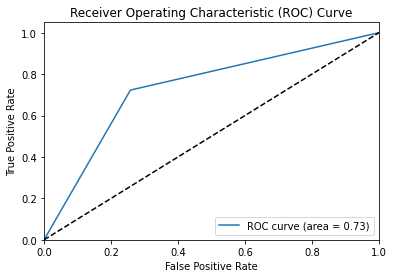

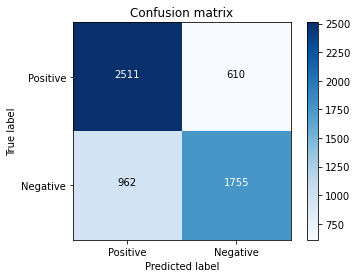

In [112]:
# Cutoff: 2
# Model 1: Logistic Regression

# Define hyperparameters for grid search
param_grid = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}

# Training an ML model here
lr = LogisticRegression(random_state=0, class_weight="balanced")
clf_lr = GridSearchCV(lr, param_grid, cv=3)
clf_lr.fit(X_train1, Y_train1)
Y_validation_pred1 = clf_lr.predict(X_validation1)

print("F1 score for Logistic Regression is", f1_score(Y_validation1, 
                                                      Y_validation_pred1, 
                                                      average='macro'))
print("Confusion matrix for Logistic Regression is", confusion_matrix(Y_validation1, 
                                                                      Y_validation_pred1))
print("AUROC for Logistic Regression is", roc_auc_score(Y_validation1, 
                                                           Y_validation_pred1))
print("Accuracy Score for Logistic Regression is", clf_lr.best_score_)
print("Best hyperparameters:", clf_lr.best_params_)

find_curves(Y_validation1, Y_validation_pred1)

F1 score for SVM is 0.7223982614607614
Confusion matrix for SVM is [[1775  590]
 [1008 2465]]
AUROC for SVM is 0.7301447773795923
Accuracy Score for Logistic Regression is 0.7350007881215448
Best hyperparameters: {'C': 10, 'loss': 'squared_hinge', 'penalty': 'l2'}


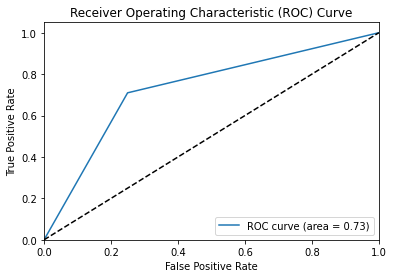

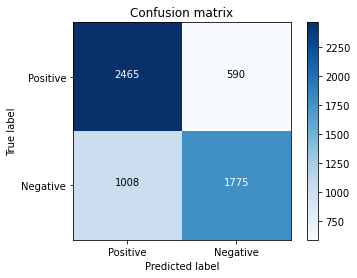

In [114]:
# Cutoff: 2
# Model 2: SVM

# Define hyperparameters for grid search
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge']
}

# Training an ML model here
svc = svm.LinearSVC(class_weight="balanced")
clf_svm = GridSearchCV(svc, param_grid, cv=3)
clf_svm.fit(X_train1, Y_train1)
Y_validation_pred2 = clf_svm.predict(X_validation1)

print("F1 score for SVM is", f1_score(Y_validation1, Y_validation_pred2, average='macro'))
print("Confusion matrix for SVM is", confusion_matrix(Y_validation1, Y_validation_pred2))
print("AUROC for SVM is", roc_auc_score(Y_validation1, Y_validation_pred2))
print("Accuracy Score for Logistic Regression is", clf_svm.best_score_)
print("Best hyperparameters:", clf_svm.best_params_)

find_curves(Y_validation1, Y_validation_pred2)

F1 score for Random Forest is 0.7184758312284611
Confusion matrix for Random Forest is [[1464  901]
 [ 654 2819]]
AUROC for Random Forest is 0.715358832771565
Accuracy Score for Logistic Regression is 0.7350435889976735
Best hyperparameters: {'max_depth': None, 'n_estimators': 200}


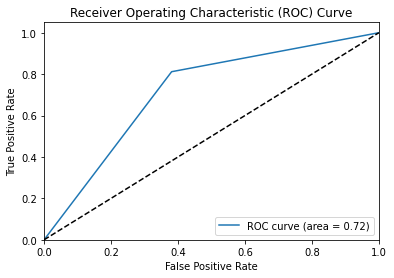

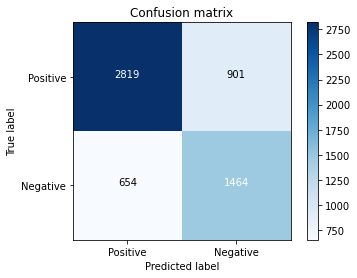

In [115]:
# Cutoff: 2
# Model 3: Random Forest

# Define hyperparameters for grid search
param_grid = {'n_estimators': [10, 200],
              'max_depth': [None, 5, 10, 20]}

# Training an ML model here
rf = RandomForestClassifier(max_depth=2, random_state=0, class_weight="balanced")
clf_rf = GridSearchCV(rf, param_grid, cv=3)
clf_rf.fit(X_train1, Y_train1)
Y_validation_pred3 = clf_rf.predict(X_validation1)

print("F1 score for Random Forest is", f1_score(Y_validation1, Y_validation_pred3, average='macro'))
print("Confusion matrix for Random Forest is", confusion_matrix(Y_validation1, 
                                                                      Y_validation_pred3))
print("AUROC for Random Forest is", roc_auc_score(Y_validation1, 
                                                           Y_validation_pred3))
print("Accuracy Score for Logistic Regression is", clf_rf.best_score_)
print("Best hyperparameters:", clf_rf.best_params_)

find_curves(Y_validation1, Y_validation_pred3)

In [116]:
# Perform the data processing here

# Cutoff: 3
X_train1 = train.iloc[:, 1:]
Y_train1 = train['overall']
Y_train1 = pd.DataFrame(Y_train1, columns = ['overall'])
X_train1, Y_train1 = data_processing(3, X_train1, Y_train1)


# Divide the training data provided into train and validation sets 
X_train1, X_validation1, Y_train1, Y_validation1 = train_test_split(X_train1, Y_train1,
                                                  test_size=0.2, train_size=0.8)


F1 score for Logistic Regression is 0.7138098971235207
Confusion matrix for Logistic Regression is [[2578  961]
 [ 666 1633]]
AUROC for Logistic Regression is 0.7193815977830331
Accuracy Score for Logistic Regression is 0.7284484411149519
Best hyperparameters: {'C': 0.1, 'penalty': 'l2'}


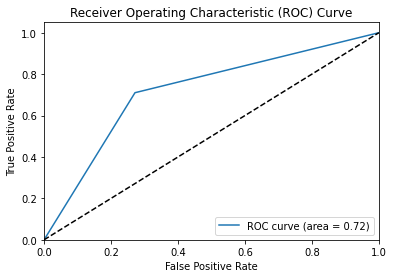

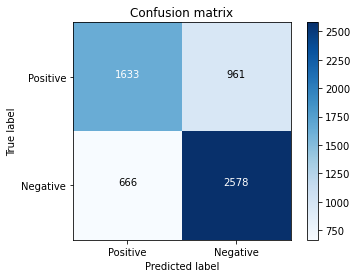

In [117]:
# Cutoff: 3
# Model 1: Logistic Regression

# Define hyperparameters for grid search
param_grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}

# Training an ML model here
lr = LogisticRegression(random_state=0, class_weight="balanced")
clf_lr = GridSearchCV(lr, param_grid, cv=3)
clf_lr.fit(X_train1, Y_train1)
Y_validation_pred1 = clf_lr.predict(X_validation1)

print("F1 score for Logistic Regression is", f1_score(Y_validation1, 
                                                      Y_validation_pred1, 
                                                      average='macro'))
print("Confusion matrix for Logistic Regression is", confusion_matrix(Y_validation1, 
                                                                      Y_validation_pred1))
print("AUROC for Logistic Regression is", roc_auc_score(Y_validation1, 
                                                           Y_validation_pred1))
print("Accuracy Score for Logistic Regression is", clf_lr.best_score_)
print("Best hyperparameters:", clf_lr.best_params_)


find_curves(Y_validation1, Y_validation_pred1)

F1 score for SVM is 0.7148140776566252
Confusion matrix for SVM is [[2546  993]
 [ 634 1665]]
AUROC for SVM is 0.721820094268046
Accuracy Score for Logistic Regression is 0.7265641021442497
Best hyperparameters: {'C': 0.1, 'loss': 'squared_hinge', 'penalty': 'l2'}


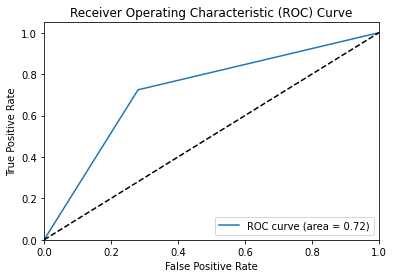

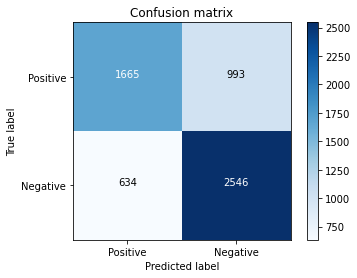

In [118]:
# Cutoff: 3
# Model 2: SVM

# Define hyperparameters for grid search
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge']
}

# Training an ML model here
svc = svm.LinearSVC(class_weight='balanced')
clf_svm = GridSearchCV(svc, param_grid, cv=3)
clf_svm.fit(X_train1, Y_train1)
Y_validation_pred2 = clf_svm.predict(X_validation1)

print("F1 score for SVM is", f1_score(Y_validation1, Y_validation_pred2, average='macro'))
print("Confusion matrix for SVM is", confusion_matrix(Y_validation1, Y_validation_pred2))
print("AUROC for SVM is", roc_auc_score(Y_validation1, Y_validation_pred2))
print("Accuracy Score for Logistic Regression is", clf_svm.best_score_)
print("Best hyperparameters:", clf_svm.best_params_)

find_curves(Y_validation1, Y_validation_pred2)

F1 score for Random Forest is 0.7104467478338348
Confusion matrix for Random Forest is [[2700  839]
 [ 782 1517]]
AUROC for Random Forest is 0.7113897451144342
Accuracy Score for Logistic Regression is 0.7271636775489944
Best hyperparameters: {'max_depth': 20, 'n_estimators': 200}


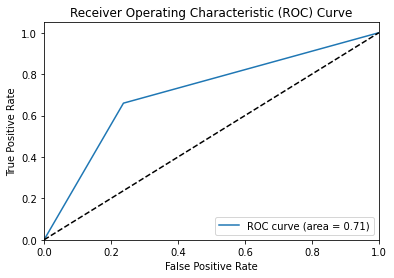

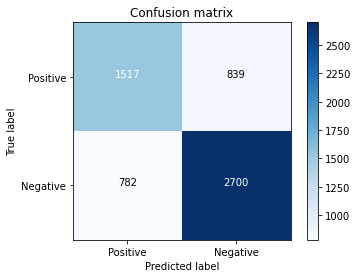

In [119]:
# Cutoff: 3
# Model 3: Random Forest

# Define hyperparameters for grid search
param_grid = {'n_estimators': [10, 200],
              'max_depth': [None, 5, 10, 20]}

# Training an ML model here
rf = RandomForestClassifier(max_depth=2, random_state=0, class_weight='balanced')
clf_rf = GridSearchCV(rf, param_grid, cv=3)
clf_rf.fit(X_train1, Y_train1)
Y_validation_pred3 = clf_rf.predict(X_validation1)

print("F1 score for Random Forest is", f1_score(Y_validation1, Y_validation_pred3, 
                                                average='macro'))
print("Confusion matrix for Random Forest is", confusion_matrix(Y_validation1, 
                                                                      Y_validation_pred3))
print("AUROC for Random Forest is", roc_auc_score(Y_validation1, 
                                                           Y_validation_pred3))
print("Accuracy Score for Logistic Regression is", clf_rf.best_score_)
print("Best hyperparameters:", clf_rf.best_params_)

find_curves(Y_validation1, Y_validation_pred3)

In [120]:
# Perform the data processing here

# Cutoff: 4
X_train1 = train.iloc[:, 1:]
Y_train1 = train['overall']
Y_train1 = pd.DataFrame(Y_train1, columns = ['overall'])
X_train1, Y_train1 = data_processing(4, X_train1, Y_train1)


# Divide the training data provided into train and validation sets 
X_train1, X_validation1, Y_train1, Y_validation1 = train_test_split(X_train1, Y_train1,
                                                  test_size=0.2, train_size=0.8)


F1 score for Logistic Regression is 0.6663834227787717
Confusion matrix for Logistic Regression is [[3531 1165]
 [ 353  789]]
AUROC for Logistic Regression is 0.721404847289641
Accuracy Score for Logistic Regression is 0.7401400184527401
Best hyperparameters: {'C': 0.1, 'penalty': 'l1'}


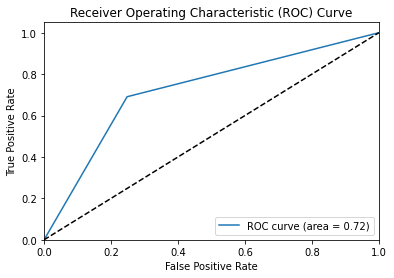

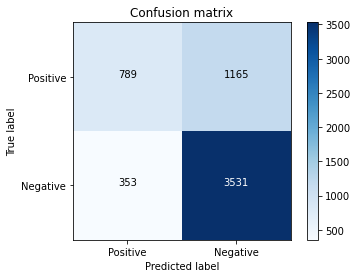

In [121]:
# Cutoff: 4
# Model 1: Logistic Regression

# Define hyperparameters for grid search
param_grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}

# Training an ML model here
lr = LogisticRegression(random_state=0, class_weight="balanced", solver="liblinear")
clf_lr = GridSearchCV(lr, param_grid, cv=3)
clf_lr.fit(X_train1, Y_train1)
Y_validation_pred1 = clf_lr.predict(X_validation1)

print("F1 score for Logistic Regression is", f1_score(Y_validation1, 
                                                      Y_validation_pred1, 
                                                      average='macro'))
print("Confusion matrix for Logistic Regression is", confusion_matrix(Y_validation1, 
                                                                      Y_validation_pred1))
print("AUROC for Logistic Regression is", roc_auc_score(Y_validation1, 
                                                           Y_validation_pred1))
print("Accuracy Score for Logistic Regression is", clf_lr.best_score_)
print("Best hyperparameters:", clf_lr.best_params_)

find_curves(Y_validation1, Y_validation_pred1)

F1 score for SVM is 0.6586451437566981
Confusion matrix for SVM is [[3447 1249]
 [ 336  806]]
AUROC for SVM is 0.7199041476592964
Accuracy Score for Logistic Regression is 0.7265643882537186
Best hyperparameters: {'C': 10, 'loss': 'squared_hinge', 'penalty': 'l2'}


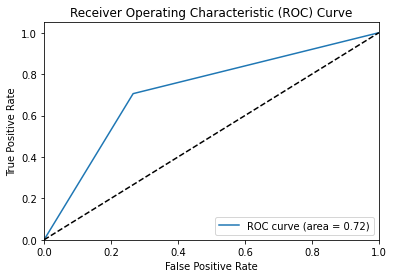

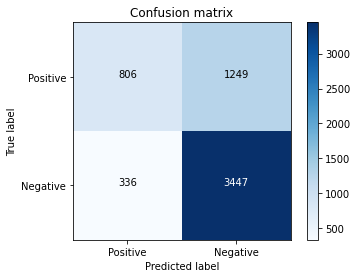

In [123]:
# Cutoff: 4
# Model 2: SVM

# Define hyperparameters for grid search
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge']
}

# Training an ML model here
svc = svm.LinearSVC(class_weight="balanced")
clf_svm = GridSearchCV(svc, param_grid, cv=3)
clf_svm.fit(X_train1, Y_train1)
Y_validation_pred2 = clf_svm.predict(X_validation1)

print("F1 score for SVM is", f1_score(Y_validation1, Y_validation_pred2, average='macro'))
print("Confusion matrix for SVM is", confusion_matrix(Y_validation1, Y_validation_pred2))
print("AUROC for SVM is", roc_auc_score(Y_validation1, Y_validation_pred2))
print("Accuracy Score for Logistic Regression is", clf_svm.best_score_)
print("Best hyperparameters:", clf_svm.best_params_)

find_curves(Y_validation1, Y_validation_pred2)

F1 score for Random Forest is 0.6551538848493164
Confusion matrix for Random Forest is [[4108  588]
 [ 652  490]]
AUROC for Random Forest is 0.6519294283318963
Accuracy Score for Logistic Regression is 0.786304694611815
Best hyperparameters: {'max_depth': None, 'n_estimators': 200}


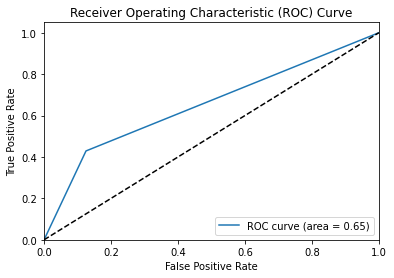

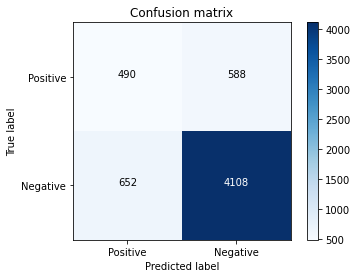

In [124]:
# Cutoff: 4
# Model 3: Random Forest

# Define hyperparameters for grid search
param_grid = {'n_estimators': [10, 200],
              'max_depth': [None, 5, 10, 20]}

# Training an ML model here
rf = RandomForestClassifier(max_depth=2, random_state=0, class_weight="balanced")
clf_rf = GridSearchCV(rf, param_grid, cv=3)
clf_rf.fit(X_train1, Y_train1)
Y_validation_pred3 = clf_rf.predict(X_validation1)

print("F1 score for Random Forest is", f1_score(Y_validation1, Y_validation_pred3, 
                                                average='macro'))
print("Confusion matrix for Random Forest is", confusion_matrix(Y_validation1, 
                                                                      Y_validation_pred3))
print("AUROC for Random Forest is", roc_auc_score(Y_validation1, 
                                                           Y_validation_pred3))
print("Accuracy Score for Logistic Regression is", clf_rf.best_score_)
print("Best hyperparameters:", clf_rf.best_params_)

find_curves(Y_validation1, Y_validation_pred3)

# Multi Class Classification

The next 3 models are used for multi class classification.

In [72]:
## Multi class classification

X_train1 = train.iloc[:, 1:]
Y_train1 = train['overall']
Y_train1 = pd.DataFrame(Y_train1, columns = ['overall'])
X_train1, Y_train1 = data_processing_multiclass(X_train1, Y_train1)


# Divide the training data provided into train and validation sets 
X_train1, X_validation1, Y_train1, Y_validation1 = train_test_split(X_train1, Y_train1,
                                                  test_size=0.2, train_size=0.8)


### Model : Logistic Regression

In [75]:
# Model 1: Logistic Regression

# Define hyperparameters for grid search
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10],
    'logisticregression__penalty': ['l1', 'l2']
}


# Training an ML model here

# Define the OvR logistic regression model
ovr_model = make_pipeline(StandardScaler(), LogisticRegression(multi_class='ovr', 
                                                               solver='sag', 
                                                               class_weight="balanced" ))

# Define the grid search object
grid_search = GridSearchCV(ovr_model, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the grid search object to the training data
grid_search.fit(X_train1, Y_train1)



In [92]:
# Predict the data
y_valid_pred = grid_search.predict(X_validation1)
print(y_valid_pred)

[4 4 3 ... 4 5 1]


[4 4 3 ... 4 5 1]


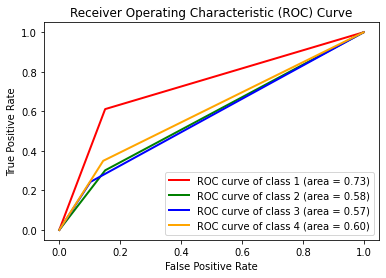

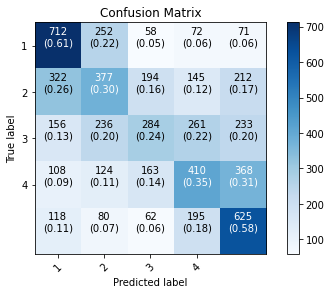

F1 score for Logistic Regression based Multi class classification is 0.40345989362474466
Confusion matrix for Logistic Regression based Multi class classification is [[712 252  58  72  71]
 [322 377 194 145 212]
 [156 236 284 261 233]
 [108 124 163 410 368]
 [118  80  62 195 625]]
Score for Logistic Regression based Multi class classification is 0.4249069455389466
Best hyperparameters: {'logisticregression__C': 1, 'logisticregression__penalty': 'l2'}


In [93]:
# calculate the ROC curve for each class

print(y_valid_pred)
fpr = dict()
tpr = dict()
roc_auc = dict()
y_valid_pred = pd.DataFrame(y_valid_pred, columns=['res'])
for i in range(4):
    # fpr[i], tpr[i], _ = roc_curve(Y_validation1['overall'].loc[Y_validation1['overall'] == (i+1)], y_valid_pred['res'].loc[y_valid_pred['res'] == i+1])
    
    y_true_binary = np.zeros(Y_validation1['overall'].shape[0])
    y_true_binary[Y_validation1['overall'] == i+1] = 1
    y_pred_binary = np.zeros(y_valid_pred['res'].shape[0])
    y_pred_binary[y_valid_pred['res'] == i+1] = 1
    fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_pred_binary)
    roc_auc[i] = auc(fpr[i], tpr[i])

# # compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(Y_validation1['overall'].ravel(), y_valid_pred['res'].ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# plot the ROC curve for each class
# plt.figure()
lw = 2
colors = ['red', 'green', 'blue', 'orange']
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

# # plot the micro-average ROC curve
# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#          ''.format(roc_auc["micro"]),
#          color='black', linestyle=':', linewidth=lw)

# add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

################################

# calculate the confusion matrix
cm = confusion_matrix(Y_validation1, y_valid_pred)

# define classes and colormap
classes = np.arange(1, 5)
cmap = plt.cm.Blues

# plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix')
plt.colorbar()

# add axis labels and tick marks
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# add text annotations
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd') + "\n({:.2f})".format(cm_normalized[i, j]),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

# add axis labels
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



print("F1 score for Logistic Regression based Multi class classification is", 
      f1_score(Y_validation1, y_valid_pred, average='macro'))
print("Confusion matrix for Logistic Regression based Multi class classification is", 
      confusion_matrix(Y_validation1, y_valid_pred))
# print("AUC-ROC score for Logistic Regression based Multi class classification is", roc_auc_score(Y_validation1, 
#                                                                        y_valid_pred,  average='macro'))
print("Score for Logistic Regression based Multi class classification is", 
      grid_search.best_score_)
print("Best hyperparameters:", grid_search.best_params_)

### Model : Linear SVC

In [94]:
# Model 2: Linear SVC

# Define the parameter grid for grid search
param_grid = {
    'linearsvc__C': [0.01, 0.1, 1, 10],
    'linearsvc__penalty': ['l1', 'l2']
}


# Training an ML model here

# Define the OvR linear SVC model
ovr_model = make_pipeline(StandardScaler(), LinearSVC(multi_class='ovr', 
                                                      dual=False, class_weight="balanced"))

# Define the grid search object
grid_search = GridSearchCV(ovr_model, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the grid search object to the training data
grid_search.fit(X_train1, Y_train1)

# Predict the data
y_valid_pred = grid_search.predict(X_validation1)


In [95]:
print(y_valid_pred)

[4 4 3 ... 5 5 1]


[4 4 3 ... 5 5 1]


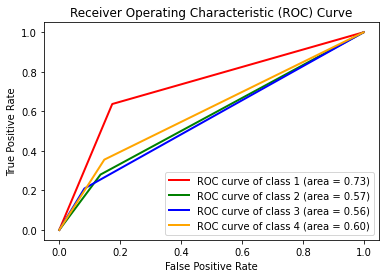

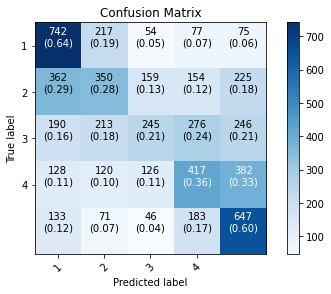

F1 score for Linear SVC based Multi class classification is 0.3972311148184553
Confusion matrix for Linear SVC based Multi class classification is [[742 217  54  77  75]
 [362 350 159 154 225]
 [190 213 245 276 246]
 [128 120 126 417 382]
 [133  71  46 183 647]]
Score for Linear SVC based Multi class classification is 0.4243502461999572
Best hyperparameters: {'linearsvc__C': 0.1, 'linearsvc__penalty': 'l1'}


In [96]:
print(y_valid_pred)
fpr = dict()
tpr = dict()
roc_auc = dict()
y_valid_pred = pd.DataFrame(y_valid_pred, columns=['res'])
for i in range(4):
    # fpr[i], tpr[i], _ = roc_curve(Y_validation1['overall'].loc[Y_validation1['overall'] == (i+1)], y_valid_pred['res'].loc[y_valid_pred['res'] == i+1])
    
    y_true_binary = np.zeros(Y_validation1['overall'].shape[0])
    y_true_binary[Y_validation1['overall'] == i+1] = 1
    y_pred_binary = np.zeros(y_valid_pred['res'].shape[0])
    y_pred_binary[y_valid_pred['res'] == i+1] = 1
    fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_pred_binary)
    roc_auc[i] = auc(fpr[i], tpr[i])

# # compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(Y_validation1['overall'].ravel(), y_valid_pred['res'].ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# plot the ROC curve for each class
# plt.figure()
lw = 2
colors = ['red', 'green', 'blue', 'orange']
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

# # plot the micro-average ROC curve
# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#          ''.format(roc_auc["micro"]),
#          color='black', linestyle=':', linewidth=lw)

# add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

################################

# calculate the confusion matrix
cm = confusion_matrix(Y_validation1, y_valid_pred)

# define classes and colormap
classes = np.arange(1, 5)
cmap = plt.cm.Blues

# plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix')
plt.colorbar()

# add axis labels and tick marks
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# add text annotations
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd') + "\n({:.2f})".format(cm_normalized[i, j]),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

# add axis labels
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


print("F1 score for Linear SVC based Multi class classification is", 
      f1_score(Y_validation1, y_valid_pred, average='macro'))
print("Confusion matrix for Linear SVC based Multi class classification is", 
      confusion_matrix(Y_validation1, y_valid_pred))
# print("AUC-ROC score for Logistic Regression based Multi class classification is", roc_auc_score(Y_validation1, 
#                                                                        y_valid_pred))
print("Score for Linear SVC based Multi class classification is", 
      grid_search.best_score_)
print("Best hyperparameters:", grid_search.best_params_)

### Model : Random Forest

In [97]:
# Model 3: Random Forest

# Define the parameter grid for grid search
param_grid = {
    'randomforestclassifier__n_estimators': [50, 100, 200],
    'randomforestclassifier__max_depth': [None, 5, 10],
    'randomforestclassifier__min_samples_split': [2, 5, 10]
}


# Training an ML model here

# Define the OvR linear SVC model
ovr_model = make_pipeline(StandardScaler(), RandomForestClassifier(n_jobs=-1, 
                                                                   random_state=42, 
                                                                   class_weight="balanced"))

# Define the grid search object
grid_search = GridSearchCV(ovr_model, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the grid search object to the training data
grid_search.fit(X_train1, Y_train1)

# Predict the data
y_valid_pred = grid_search.predict(X_validation1)


In [99]:
print(y_valid_pred)

[4 4 3 ... 5 5 1]


[4 4 3 ... 5 5 1]


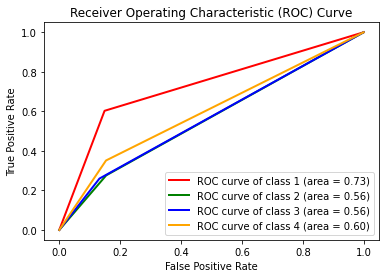

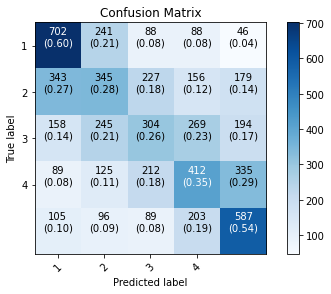

F1 score for Linear SVC based Multi class classification is 0.396337314526243
Confusion matrix for Linear SVC based Multi class classification is [[702 241  88  88  46]
 [343 345 227 156 179]
 [158 245 304 269 194]
 [ 89 125 212 412 335]
 [105  96  89 203 587]]
Score for Linear SVC based Multi class classification is 0.409019073906747
Best hyperparameters: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 200}


In [101]:
print(y_valid_pred)
fpr = dict()
tpr = dict()
roc_auc = dict()
y_valid_pred = pd.DataFrame(y_valid_pred, columns=['res'])
for i in range(4):
    # fpr[i], tpr[i], _ = roc_curve(Y_validation1['overall'].loc[Y_validation1['overall'] == (i+1)], y_valid_pred['res'].loc[y_valid_pred['res'] == i+1])
    
    y_true_binary = np.zeros(Y_validation1['overall'].shape[0])
    y_true_binary[Y_validation1['overall'] == i+1] = 1
    y_pred_binary = np.zeros(y_valid_pred['res'].shape[0])
    y_pred_binary[y_valid_pred['res'] == i+1] = 1
    fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_pred_binary)
    roc_auc[i] = auc(fpr[i], tpr[i])

# # compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(Y_validation1['overall'].ravel(), y_valid_pred['res'].ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# plot the ROC curve for each class
# plt.figure()
lw = 2
colors = ['red', 'green', 'blue', 'orange']
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

# # plot the micro-average ROC curve
# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#          ''.format(roc_auc["micro"]),
#          color='black', linestyle=':', linewidth=lw)

# add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

################################

# calculate the confusion matrix
cm = confusion_matrix(Y_validation1, y_valid_pred)

# define classes and colormap
classes = np.arange(1, 5)
cmap = plt.cm.Blues

# plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix')
plt.colorbar()

# add axis labels and tick marks
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# add text annotations
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd') + "\n({:.2f})".format(cm_normalized[i, j]),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

# add axis labels
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


print("F1 score for Linear SVC based Multi class classification is", 
      f1_score(Y_validation1, y_valid_pred, average='macro'))
print("Confusion matrix for Linear SVC based Multi class classification is", 
      confusion_matrix(Y_validation1, y_valid_pred))
# print("AUC-ROC score for Logistic Regression based Multi class classification is", roc_auc_score(Y_validation1, 
#                                                                        y_valid_pred))
print("Score for Linear SVC based Multi class classification is", 
      grid_search.best_score_)
print("Best hyperparameters:", grid_search.best_params_)

# Clustering Algorithm: KMeans

In [58]:
## Clustering Problem

X_train1 = train.iloc[:, 1:]
Y_train1 = train['category']
Y_train1 = pd.DataFrame(Y_train1, columns = ['category'])
X_train1, Y_train1 = data_processing_multiclass(X_train1, Y_train1, True)

# print(Y_train1)
Y_train1 = Y_train1.squeeze()
kmeans = KMeans(n_clusters=6, random_state=42, n_init="auto")
y_pred = kmeans.fit_predict(X_train1)
print(silhouette_score(X_train1, kmeans.labels_))
print(adjusted_rand_score(Y_train1, y_pred))

0.599190380028831
0.006850490923692817


In [88]:
print(np.count_nonzero(y_pred == 1))

4500
(4500, 8)


In [ ]:
# predict the label of the test samples here using the model
# for this example we will simply predict all 0's
test_predicted =  [0]*len(test)

In [ ]:
# IMPORTANT: use 'id' and 'predicted' as the column names
test_ids = list(test.index) # the 'id' column name is the index of the test samples

In [ ]:
test_submission = pd.DataFrame({'id':test_ids, 'predicted':test_predicted})
print(test_submission.shape) # should be (4500, 2)
test_submission.head()

In [ ]:
test_submission.to_csv('test_submission_part_1.csv', index=False)